In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy import stats

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

y_original=y_original[['Unnamed: 0','S000502']]

print(x_original.shape)
print(y_original.shape)


(159381, 408)
(159381, 2)


In [3]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')

In [4]:
# data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
# data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

In [5]:
# change field 38 to 3 group
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)
print(data.shape)

(159381, 409)


In [6]:
# add Class to the dataset
# _class = []
# for i in range(data.shape[0]):
#     if (data.S000501[i] >= 140) | (data.S000502[i] >= 90):
#         _class.append(2)
#     elif (data.S000501[i] < 120) & (data.S000502[i] < 80):
#         _class.append(0)
#     else:
#         _class.append(1)
# data["CLASS"] = _class

# print(data.shape)

In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  

print(data.shape)

(159174, 409)


In [8]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
# categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

Calculate correlation Value - for numerical values
========

In [9]:
corr=data[numerical_cols].corr()
corr=corr.S000502_y
corrvalPD=pd.DataFrame()
corrvalPD['Col']=corr.index
corrvalPD['val']=abs(corr.values)

corrvalPD=corrvalPD.sort_values(by='val',ascending=False)
corrvalPD.head()

,Col,val
277,S000502_y,1.000000
133,L393800,1.000000
70,L122000,0.895956
152,L501900,0.858531
128,L359000,0.800269


In [10]:
# count of none NA values of feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,Unnamed: 0,159174
1,index,159174
2,COMPARE,159174
3,AGE,159174
4,B_DAY,159174


In [11]:
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 50000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(20)

,Col,val,Count
0,S000502_y,1.000000,159105
9,S000502_x,0.583259,159098
10,S000501,0.573768,159098
20,S000300,0.365555,158868
24,L190400,0.323091,159034
26,L190300,0.314889,158997
27,L190500,0.311933,158997
28,L100700,0.307348,152279
32,L103300,0.267393,135047
34,L103000,0.251706,158732


In [12]:
print(list(mergedColCorrCount.head(20).Col))

['S000502_y', 'S000502_x', 'S000501', 'S000300', 'L190400', 'L190300', 'L190500', 'L100700', 'L103300', 'L103000', 'L100500', 'L101700', 'L100800', 'L101300', 'S000100', 'L103100', 'B_DAY', 'AGE', 'S010102', 'S010101']


Anova test - For categorical values [Questionnaire answers]
=======

In [13]:
mydataset = data.copy()[categorical_cols]  # [np.insert(categorical_cols,0,'L100800')]

# mydataset=mydataset.drop(columns=['FIELD_1','FIELD_2','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39','FIELD_88',
#                            'FIELD_89','FIELD_109','FIELD_110','FIELD_111','FIELD_70','FIELD_82','FIELD_85','FIELD_91',
#                            'FIELD_103','FIELD_106'])

# mydataset=mydataset.drop(columns=['FIELD_1','FIELD_2','FIELD_87','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39',
#                                   'FIELD_88','FIELD_89', 'FIELD_108','FIELD_109','FIELD_110','FIELD_111','FIELD_82',
#                                  'FIELD_91','FIELD_103','FIELD_118','FIELD_119','FIELD_120','FIELD_121','FIELD_122',
#                                  'FIELD_123','FIELD_124','FIELD_125','FIELD_126','FIELD_127','FIELD_128','FIELD_129',
#                                  'FIELD_130','FIELD_131','FIELD_132','FIELD_133','FIELD_134','FIELD_135','FIELD_136',
#                                   'FIELD_137','FIELD_138','FIELD_139','FIELD_140'])


mydataset = mydataset.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_87",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_108",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_82",
        "FIELD_91",
        "FIELD_103",
        "FIELD_118",
        "FIELD_119",
        "FIELD_120",
        "FIELD_121",
        "FIELD_122",
        "FIELD_123",
        "FIELD_124",
        "FIELD_125",
        "FIELD_126",
        "FIELD_127",
        "FIELD_128",
        "FIELD_129",
        "FIELD_130",
        "FIELD_131",
        "FIELD_132",
        "FIELD_133",
        "FIELD_134",
        "FIELD_135",
        "FIELD_136",
        "FIELD_137",
        "FIELD_138",
        "FIELD_139",
        "FIELD_140",
        "FIELD_64",
        "FIELD_65",
        "FIELD_66",
        "FIELD_67",
        "FIELD_68",
        "FIELD_69",
        "FIELD_70",
        "FIELD_72",
        "FIELD_73",
        "FIELD_74",
        "FIELD_75",
        "FIELD_76",
        "FIELD_77",
        "FIELD_80",
        "FIELD_81",
        "FIELD_84",
        "FIELD_85",
        "FIELD_90",
        "FIELD_93",
        "FIELD_94",
        "FIELD_95",
        "FIELD_96",
        "FIELD_97",
        "FIELD_98",
        "FIELD_101",
        "FIELD_102",
        "FIELD_105",
        "FIELD_106",
        "FIELD_112",
        "FIELD_113",
        "FIELD_114",
        "FIELD_115",
        "FIELD_116",
        "FIELD_117",
        "FIELD_118",
        "FIELD_119",
        "FIELD_9",
    ]
)


mydataset = mydataset.drop(mydataset[mydataset.FIELD_3 == "`"].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_3 == "G"].index)


mydataset = mydataset.drop(mydataset[mydataset.FIELD_4 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_5 == "."].index)

mydataset = mydataset.drop(mydataset[mydataset.FIELD_35 == "?"].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_35 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_36 == "."].index)
mydataset = mydataset.drop(mydataset[mydataset.FIELD_37 == "\\"].index)

# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '7+' ].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '5~7'].index)
# mydataset=mydataset.drop(mydataset[mydataset.FIELD_39 == '3-4'].index)


# mydataset=mydataset.drop(mydataset[mydataset.FIELD_95=='.'].index)

In [15]:
colslist = mydataset.columns
DiabeticColVals = data.S000502_y

cor = []
pval = []
count = []

for i in range(len(colslist)):
    print(i, colslist[i])

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]].astype(float)
    temp = temp.dropna()
    count.append(temp.shape[0])

    uniquevalues = temp.b.unique()

    selectedGroupVals = []
    for k in range(len(uniquevalues)):
        selectedGroupVals.append(np.asarray(temp[temp["b"] == uniquevalues[k]].a))

    F, p = stats.f_oneway(*selectedGroupVals)
    cor.append(F)
    pval.append(p)

0 FIELD_3
1 FIELD_4
2 FIELD_5
3 FIELD_13
4 FIELD_14
5 FIELD_15
6 FIELD_16
7 FIELD_17
8 FIELD_18
9 FIELD_19
10 FIELD_20
11 FIELD_21
12 FIELD_22
13 FIELD_23
14 FIELD_24
15 FIELD_25
16 FIELD_26
17 FIELD_27
18 FIELD_28
19 FIELD_29
20 FIELD_30
21 FIELD_31
22 FIELD_32
23 FIELD_33
24 FIELD_34
25 FIELD_35
26 FIELD_36
27 FIELD_37
28 FIELD_38
29 FIELD_40
30 FIELD_41
31 FIELD_42
32 FIELD_43
33 FIELD_44
34 FIELD_45
35 FIELD_46
36 FIELD_47
37 FIELD_48
38 FIELD_49
39 FIELD_50
40 FIELD_51
41 FIELD_52
42 FIELD_53
43 FIELD_54
44 FIELD_55
45 FIELD_56
46 FIELD_57
47 FIELD_58
48 FIELD_59
49 FIELD_60
50 FIELD_61
51 FIELD_62
52 FIELD_63
53 FIELD_38_C
54 SEX


In [16]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [17]:
FvalPvalCorr[FvalPvalCorr.Count > 50000].head(10)

,Cols,F,P,Count
54,SEX,19487.324956,0.000000e+00,159103
53,FIELD_38_C,2062.642190,0.000000e+00,158805
23,FIELD_33,1587.742153,0.000000e+00,158793
28,FIELD_38,849.087859,0.000000e+00,158805
19,FIELD_29,233.748152,9.897665e-53,159087
17,FIELD_27,232.045712,2.324043e-52,159087
29,FIELD_40,188.896641,3.818843e-280,158810
30,FIELD_41,101.439861,1.010252e-148,158778
31,FIELD_42,23.011463,1.495441e-35,158756
18,FIELD_28,14.869535,1.152540e-04,159088


In [18]:
print(list(FvalPvalCorr[FvalPvalCorr.Count > 50000].Cols)[:10])

['SEX', 'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_41', 'FIELD_42', 'FIELD_28']


========================= LASSO method
================

In [32]:
selectedcols = ['S000502_y', 'S000502_x', 'S000501', 'S000300', 'L100700', 'L103300', 'L103000', 'L100500', 
                'L101700', 'L100800', 'L101300', 'S000100', 'L103100', 'AGE', 'S010102', 'S010101', 
                'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_41', 
                'FIELD_42', 'FIELD_28'
]
data2 = data[selectedcols].copy().dropna()
print(data2.shape)

(113267, 25)


In [33]:
x = data2[
    [
     'S000502_x', 'S000501', 'S000300', 'L100700', 'L103300', 'L103000', 'L100500', 
                'L101700', 'L100800', 'L101300', 'S000100', 'L103100', 'AGE', 'S010102', 'S010101', 
                'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_41', 
                'FIELD_42', 'FIELD_28'
    ]
]
y = data2.S000502_y

In [34]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(x, y)

print(clf.coef_)

print(clf.intercept_)

# pd.DataFrame([x.columns.ravel(),clf.coef_.ravel()],columns=['Name','coeff'])

lassod = pd.DataFrame()
lassod["Name"] = x.columns
lassod["coeff"] = clf.coef_
lassod

lassod = lassod.drop(lassod[lassod.coeff == 0].index)
lassod.coeff = abs(lassod.coeff)
lassod = lassod.sort_values(by="coeff", ascending=False)
lassod

[ 0.32558746  0.17486605  0.21822088  0.31815518  0.          0.00146782
  0.          0.00725758  0.01086077  0.00351315  0.01890661 -0.01372284
  0.0606105   0.04224928  0.01259055  0.          0.          0.20928647
  0.          0.          0.          0.         -0.          0.        ]
14.731411460000452


,Name,coeff
0,S000502_x,0.325587
3,L100700,0.318155
2,S000300,0.218221
17,FIELD_38,0.209286
1,S000501,0.174866
12,AGE,0.060611
13,S010102,0.042249
10,S000100,0.018907
11,L103100,0.013723
14,S010101,0.012591


In [35]:
print(list(lassod.Name[:16]))

['S000502_x', 'L100700', 'S000300', 'FIELD_38', 'S000501', 'AGE', 'S010102', 'S000100', 'L103100', 'S010101', 'L100800', 'L101700', 'L101300', 'L103000']


=============================== SelectKBest method
========================

In [41]:
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:16]))

['S000502_x', 'S000501', 'S000300', 'L100700', 'L103300', 'L103000', 'L100500', 'L101700', 'L100800', 'L101300', 'S000100', 'L103100', 'AGE', 'S010102', 'S010101', 'FIELD_38_C']


========================================= LinearSVC
===============

In [42]:
# from sklearn.svm import LinearSVC
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectFromModel

# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x, y)
# model = SelectFromModel(lsvc, prefit=True)
# X_new = model.transform(x)
# X_new.shape

In [43]:
# X_new

================================ SequentialFeatureSelector 
================================

In [44]:
# from sklearn.linear_model import LinearRegression
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# from sklearn.ensemble import RandomForestRegressor

# lr = RandomForestRegressor()

# sfs = SFS(lr,
#           k_features=13,
#           forward=True,
#           floating=False,
#           scoring='neg_mean_squared_error',
#           cv=5)

# sfs = sfs.fit(x, y)
# fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

================================= feature_importances
=====

[0.05966157 0.06214184 0.05646322 0.05530842 0.05382027 0.05566048
 0.04565914 0.05397332 0.0545386  0.05414834 0.05428512 0.05400941
 0.05412657 0.05058526 0.05035089 0.00504697 0.01754123 0.01710493
 0.00653429 0.00636343 0.03584307 0.04120538 0.04808044 0.00754781]


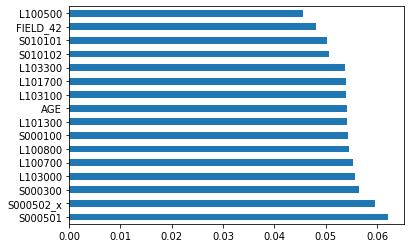

S000501      0.062142
S000502_x    0.059662
S000300      0.056463
L103000      0.055660
L100700      0.055308
L100800      0.054539
S000100      0.054285
L101300      0.054148
AGE          0.054127
L103100      0.054009
L101700      0.053973
L103300      0.053820
S010102      0.050585
S010101      0.050351
FIELD_42     0.048080
L100500      0.045659
dtype: float64
Index(['S000501', 'S000502_x', 'S000300', 'L103000', 'L100700', 'L100800',
       'S000100', 'L101300', 'AGE', 'L103100', 'L101700', 'L103300', 'S010102',
       'S010101', 'FIELD_42', 'L100500'],
      dtype='object')


In [45]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16))
print(feat_importances.nlargest(16).index)


============================= Backward Elimination
========

In [28]:
import statsmodels.regression.linear_model as sm

temp = x.copy()
temp["const"] = np.ones((x.shape[0], 1))
regressor_OLS = sm.OLS(endog=y, exog=temp).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S000502_y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     2839.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:15:11   Log-Likelihood:            -3.8140e+05
No. Observations:              113260   AIC:                         7.629e+05
Df Residuals:                  113231   BIC:                         7.631e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
S000502_x      0.3184      0.004     87.247      0.000       0.311       0.326
S000501        0.1684      0.003     60.699      0.000       0.163       0.174
S000300        0.2093      0.008     24.872      0.000       0.193       0.226
L190400        0.4192      0.056      7.499      0.000       0.310       0.529
L190300        1.7325      0.104     16.583      0.000       1.528       1.937
L190500       -0.2054      0.023     -8.873      0.000      -0.251      -0.160
L100700        0.2562      0.022     11.841      0.000       0.214       0.299
L103300       -0.0254      0.034     -0.742      0.458      -0.093       0.042
L103000        0.0009      0.000      2.842      0.004       0.000       0.002
L100500       -0.3128      0.173     -1.806      0.071      -0.652       0.027
L101700        0.0066      0.001      9.914      0.000       0.005       0.008
L100800        0.0090      0.002      4.318      0.000       0.005       0.013
L101300        0.0003      0.001      0.261      0.794      -0.002       0.003
S000100       -0.0122      0.004     -3.100      0.002      -0.020      -0.004
L103100       -0.0083      0.003     -3.236      0.001      -0.013      -0.003
AGE            0.0661      0.003     23.611      0.000       0.061       0.072
S010102        0.0438      0.012      3.690      0.000       0.021       0.067
S010101        0.0176      0.012      1.498      0.134      -0.005       0.041
SEX           -0.3612      0.099     -3.643      0.000      -0.555      -0.167
FIELD_38_C    -0.0856      0.073     -1.176      0.239      -0.228       0.057
FIELD_33       0.0828      0.032      2.559      0.011       0.019       0.146
FIELD_38       0.3022      0.032      9.463      0.000       0.240       0.365
FIELD_29       0.7120      0.061     11.604      0.000       0.592       0.832
FIELD_27       0.1563      0.088      1.771      0.077      -0.017       0.329
FIELD_40       0.0010      0.018      0.055      0.956      -0.034       0.036
FIELD_41       0.0111      0.017      0.649      0.516      -0.022       0.045
FIELD_42      -0.0159      0.010     -1.588      0.112      -0.036       0.004
FIELD_28      -0.1151      0.094     -1.220      0.222      -0.300       0.070
const         16.4815      0.867     19.012      0.000      14.782      18.181
==============================================================================
Omnibus:                     1026.350   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1065.473
Skew:                           0.224   Prob(JB):                    4.32e-232
Kurtosis:                       3.159   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [29]:
temp = temp.drop(
    columns=[
        "L103000",
        "L103300",
        "L190300",
        "FIELD_40",
        "FIELD_27",
        "FIELD_29",
        "FIELD_21",
        "FIELD_5",
        "FIELD_14",
    ]
)
regressor_OLS = sm.OLS(endog=y, exog=temp).fit()
regressor_OLS.summary()

KeyError: "['FIELD_21' 'FIELD_5' 'FIELD_14'] not found in axis"

In [ ]:
temp=temp.drop(columns=['FIELD_33'])
regressor_OLS = sm.OLS(endog = y, exog = temp).fit()
regressor_OLS.summary()

In [ ]:
temp.columns

======================== variance inflation factor 
=============

In [30]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [31]:
newcols = vifcal(data2, "S000502_y")
print(newcols, len(newcols))

0 ,  S000502_x  VIF =  2.5
1 ,  S000501  VIF =  2.71
2 ,  S000300  VIF =  1.67
3 ,  L190400  VIF =  16.37
4 ,  L190300  VIF =  5.08
5 ,  L190500  VIF =  20.67
6 ,  L100700  VIF =  2.02
7 ,  L103300  VIF =  3.26
8 ,  L103000  VIF =  1.89
9 ,  L100500  VIF =  2.16
10 ,  L101700  VIF =  1.54
11 ,  L100800  VIF =  1.3
12 ,  L101300  VIF =  1.46
13 ,  S000100  VIF =  2.47
14 ,  L103100  VIF =  2.48
15 ,  AGE  VIF =  1.37
16 ,  S010102  VIF =  2.69
17 ,  S010101  VIF =  2.69
18 ,  SEX  VIF =  5.32
19 ,  FIELD_38_C  VIF =  3.62
20 ,  FIELD_33  VIF =  1.63
21 ,  FIELD_38  VIF =  3.76
22 ,  FIELD_29  VIF =  1.05
23 ,  FIELD_27  VIF =  1.04
24 ,  FIELD_40  VIF =  1.65
25 ,  FIELD_41  VIF =  1.76
26 ,  FIELD_42  VIF =  1.15
27 ,  FIELD_28  VIF =  1.02
['S000502_x', 'S000501', 'S000300', 'L100700', 'L103300', 'L103000', 'L100500', 'L101700', 'L100800', 'L101300', 'S000100', 'L103100', 'AGE', 'S010102', 'S010101', 'FIELD_38_C', 'FIELD_33', 'FIELD_38', 'FIELD_29', 'FIELD_27', 'FIELD_40', 'FIELD_41',